In [1]:
import time
t1 = time.time()

import math
import os
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers
from sklearn.metrics import confusion_matrix
import tensorflow.keras.backend as K
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

2025-07-01 07:02:19.618812: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
##### load image data #####

image_path = "/root/data/data_image.h5"
image_file = h5py.File(image_path, 'r')
image_file.keys()

<KeysViewHDF5 ['jjBG', 'sig', 'ttbarBG']>

In [3]:
sig_len = 470063
jjBG_len = 270777
ttbarBG_len = 548709

print("signal length", sig_len)
print("jjBG length", jjBG_len)
print("ttbarBG length", ttbarBG_len)

total_image = np.concatenate((image_file['sig'][:], image_file['jjBG'][:], image_file['ttbarBG'][:]))
print("total image shape", np.shape(total_image))

print("Time:", time.time()-t1)

signal length 470063
jjBG length 270777
ttbarBG length 548709
total image shape (1289549, 3, 50, 50)
Time: 182.30436420440674


In [4]:
##### make target #####

target = np.zeros(sig_len + jjBG_len + ttbarBG_len)
target[0:sig_len] = 1    ### signal label as 1
print(target)
print("target shape", np.shape(target))

[1. 1. 1. ... 0. 0. 0.]
target shape (1289549,)


In [5]:
##### split the data into training, validation and test data #####

train_image, val_image, train_target, val_target = train_test_split(total_image, target, test_size=0.2)

print("training data shape:", np.shape(train_image), np.shape(train_target))
print("validation data shape:", np.shape(val_image), np.shape(val_target))

training data shape: (1031639, 3, 50, 50) (1031639,)
validation data shape: (257910, 3, 50, 50) (257910,)


In [6]:
##### build CNN model #####

CNN_model = Sequential()
CNN_model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu',data_format='channels_first', kernel_initializer='he_normal', input_shape=(3,50,50)))
CNN_model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu',data_format='channels_first', kernel_initializer='he_normal'))
CNN_model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1), data_format='channels_first'))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling2D((2,2)))
CNN_model.add(Dropout(0.1))

CNN_model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu',data_format='channels_first', kernel_initializer='he_normal'))
CNN_model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu',data_format='channels_first', kernel_initializer='he_normal'))
CNN_model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1), data_format='channels_first'))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling2D((2,2)))
CNN_model.add(Dropout(0.1))

CNN_model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu',data_format='channels_first', kernel_initializer='he_normal'))
CNN_model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu',data_format='channels_first', kernel_initializer='he_normal'))
CNN_model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1), data_format='channels_first'))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling2D((2,2)))
CNN_model.add(Dropout(0.1))

CNN_model.add(Flatten())
CNN_model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
CNN_model.add(BatchNormalization())
CNN_model.add(Dropout(0.3))
CNN_model.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=1e-4)
CNN_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy","mse"])

CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 48, 48)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 46, 46)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 45, 45)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 32, 45, 45)        180       
 Normalization)                                                  
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 22, 45)        0         
 g2D)                                                            
                                                        

2025-07-01 07:05:44.040239: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46696 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-07-01 07:05:44.041047: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46696 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6


                                                                 
 flatten (Flatten)           (None, 1120)              0         
                                                                 
 dense (Dense)               (None, 256)               286976    
                                                                 
 batch_normalization_3 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 400513 (1.53 MB)
Trainable params: 399761 (1.52 MB)
Non-trainable params: 752 (2.94 KB)
_________________________________________________________________


2025-07-01 07:06:58.882353: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30949170000 exceeds 10% of free system memory.
2025-07-01 07:07:16.504492: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30949170000 exceeds 10% of free system memory.


Epoch 1/100


2025-07-01 07:07:28.483337: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-07-01 07:07:31.380265: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-07-01 07:07:33.169225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-07-01 07:07:33.178360: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x564901b2b290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-01 07:07:33.178428: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-07-01 07:07:33.178440: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecut

1008/1008 [==============================] - 97s 86ms/step - loss: 0.6233 - accuracy: 0.6789 - mse: 0.2086 - val_loss: 0.5569 - val_accuracy: 0.7203 - val_mse: 0.1864
Epoch 2/100
1008/1008 [==============================] - 74s 73ms/step - loss: 0.5430 - accuracy: 0.7353 - mse: 0.1785 - val_loss: 0.5310 - val_accuracy: 0.7425 - val_mse: 0.1752
Epoch 3/100
1008/1008 [==============================] - 75s 74ms/step - loss: 0.5105 - accuracy: 0.7531 - mse: 0.1673 - val_loss: 0.5109 - val_accuracy: 0.7543 - val_mse: 0.1675
Epoch 4/100
1008/1008 [==============================] - 74s 74ms/step - loss: 0.4900 - accuracy: 0.7641 - mse: 0.1604 - val_loss: 0.4756 - val_accuracy: 0.7718 - val_mse: 0.1560
Epoch 5/100
1008/1008 [==============================] - 73s 73ms/step - loss: 0.4755 - accuracy: 0.7722 - mse: 0.1555 - val_loss: 0.4696 - val_accuracy: 0.7756 - val_mse: 0.1537
Epoch 6/100
1008/1008 [==============================] - 74s 73ms/step - loss: 0.4644 - accuracy: 0.7780 - mse: 0.151

/root/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


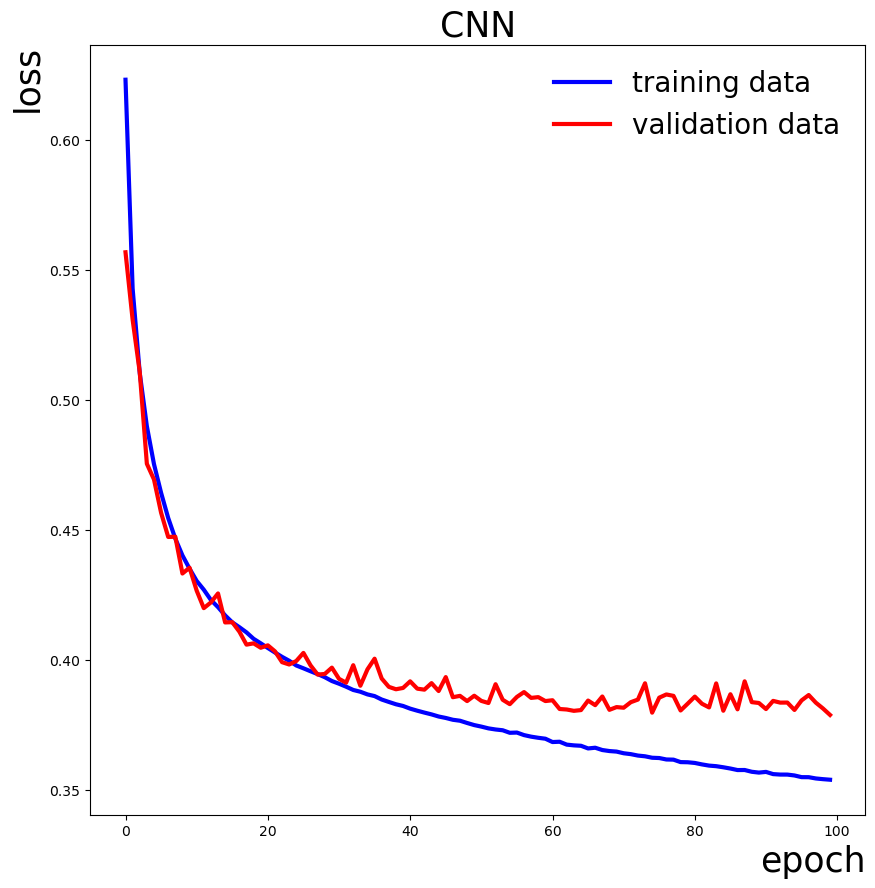

In [7]:
##### training model #####

batch_size = 1024
epochs = 100

tr_CNN_model = CNN_model.fit(train_image, train_target, validation_data=(val_image, val_target), batch_size=batch_size, epochs=epochs, verbose=1)
CNN_model.save("/root/data/model_CNN.h5")

### plot learning curve

fig, ax = plt.subplots(1,1, figsize=(10,10))
plt.plot(tr_CNN_model.history["loss"], label='training data',c='blue',linewidth = 3)
plt.plot(tr_CNN_model.history["val_loss"], label='validation data',c='red',linewidth = 3)
plt.title("CNN", fontsize=25)
ax.set_ylabel('loss', fontsize=25,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)

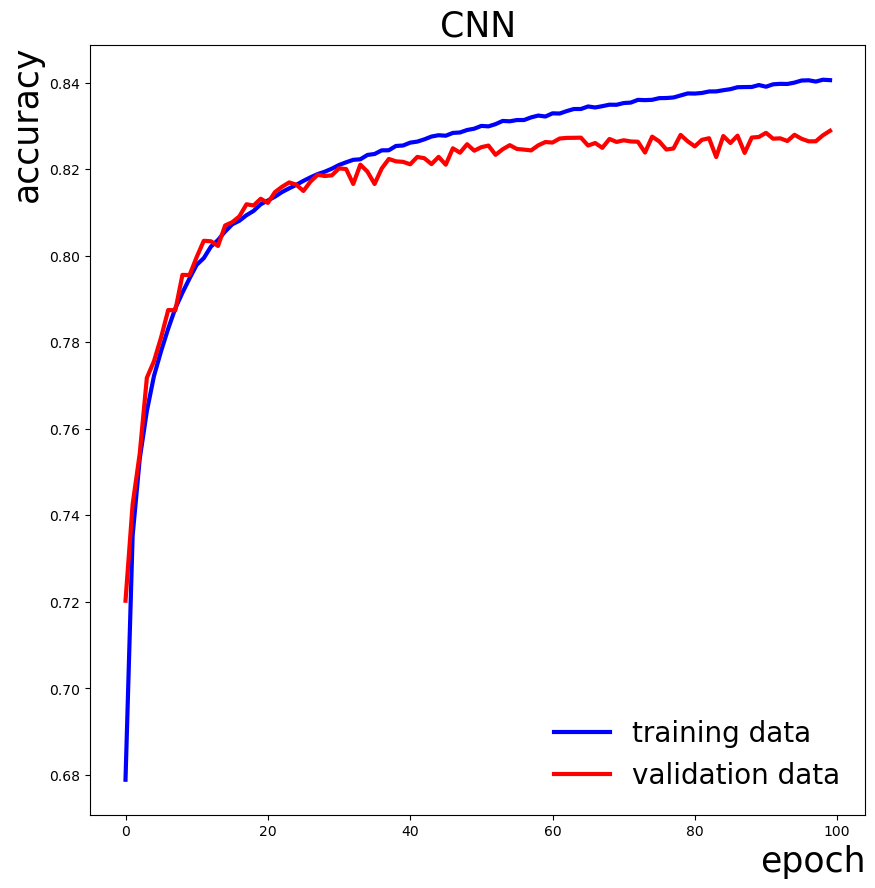

In [9]:
### plot learning curve

fig, ax = plt.subplots(1,1, figsize=(10,10))
plt.plot(tr_CNN_model.history["accuracy"], label='training data',c='blue',linewidth = 3)
plt.plot(tr_CNN_model.history["val_accuracy"], label='validation data',c='red',linewidth = 3)
plt.title("CNN", fontsize=25)
ax.set_ylabel('accuracy', fontsize=25,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)

In [8]:
image_file.close()
t2 = time.time()
print("Total time (s): ", t2-t1)

Total time (s):  7592.442521810532
